# Pipeline Research
when developing a pipeline, I use this notebook to play around with the data and see what I can do with it.

In [1]:
"""
Preprocessing pipeline
"""
from preprocess.keyword_extractor import DefaultKeywordExtractor
from datasets.docs_dataset import DbDocsDataset
from datasets.stock_dataset import StockMeta
from preprocess.preprocess_pipeline import PreprocessPipeline, PreprocessPipeLineConfig
from preprocess.docs_filterer import DefaultFilterer
from preprocess.docs_labeler import DefaultDocsLabeler
from preprocess.vectorlizer import TFIDFVectorlizer
from preprocess.labeled_docs_filterer import Near0returnFilterer


docs_dataset = DbDocsDataset()
stock_meta = StockMeta(stock_meta_path="./organized_data/stock_metadata.csv")
stock_name = '台積電'
stock = stock_meta.get_stock_by_name(stock_name)

pipeline_config = PreprocessPipeLineConfig(
    docs_filterer=DefaultFilterer(max_docs=None),
    docs_labeler=DefaultDocsLabeler(s=3),
    keywords_extractor=DefaultKeywordExtractor(),
    vectorizer=TFIDFVectorlizer()
)

pipeline = PreprocessPipeline(pipeline_config)

dataset = pipeline.preprocess(docs_dataset, stock, verbose=True)


[DefaultFilterer] filtering documents by whether doc title or content contains the stock name
load from cache: tmp/default_filterer/台積電.pkl

[DefaultDocsLabeler] labeling documents by the s day future return percentage of the stock...


labeling documents: 100%|██████████| 1026/1026 [00:05<00:00, 203.90it/s]



[Near 0 return filterer] filtering out documents with return close to 0 within 0.01


filtering documents: 100%|██████████| 121778/121778 [00:00<00:00, 3026216.81it/s]


left with 118836 documents after filtering

[DefaultKeywordExtractor] extract keywords from documents using jieba


extracting keywords: 100%|██████████| 118836/118836 [00:00<00:00, 2269076.00it/s]


remove 1018 docs because of empty keywords
left with 117818 docs

[BaselineVectorlizer] converting 117818 docs to vectors
transformers fitting...
vectorizer fitted.


fitting model...
model prediction...
calculating performance metrics...
Training accuracy: 0.7400110340144715
Validation accuracy: 0.647895094211509

Training classification report:
              precision    recall  f1-score   support

      fallen       0.77      0.64      0.70     44607
       risen       0.72      0.83      0.77     49647

    accuracy                           0.74     94254
   macro avg       0.75      0.73      0.74     94254
weighted avg       0.74      0.74      0.74     94254


Validation classification report:
              precision    recall  f1-score   support

      fallen       0.66      0.53      0.59     11163
       risen       0.64      0.75      0.69     12401

    accuracy                           0.65     23564
   macro avg       0.65      0.64      0.64     23564
weighted avg       0.65      0.65      0.64     23564



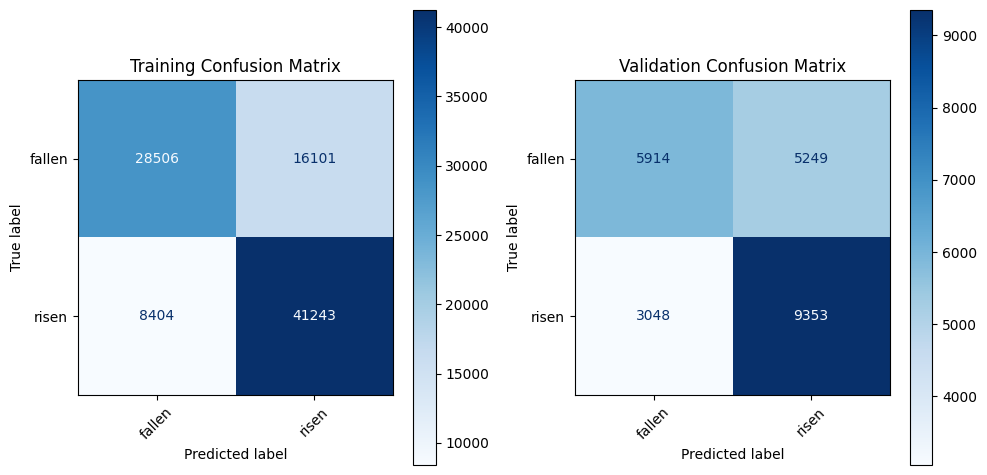

In [2]:
"""
Train & validate model
"""
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from model_evaluation import train_val_model, display_evaluation_result
from utils.data import random_split_train_val

# set model and datasets
model = SVR()
train_dataset, val_dataset = random_split_train_val(dataset, 0.8)

# train and validate model
result = train_val_model(model, train_dataset, val_dataset)

# display result
display_evaluation_result(result)

In [ ]:
val_dataset.features[0].shape